# MRT-3 Ridership Prediction and Model Comparison Using Linear and Random Forest Regression

# PART 1 — Setup, cleaning, feature engineering, and EDA

# Imports & display settings

In [17]:
# Imports & display / plot settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# statsmodels for some diagnostics
import statsmodels.api as sm

# Display settings for Colab
plt.style.use('seaborn-v0_8')
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.2f}'.format
sns.set_context("notebook", font_scale=1.1)

This cell imports the libraries we need:

pandas, numpy: data manipulation.

matplotlib, seaborn: charts. plt.style.use('seaborn-v0_8') makes charts look modern and clean.

scikit-learn: preprocessing, models, evaluation, hyperparameter search.

statsmodels: provides some statistical tests and Q-Q plots for linear regression diagnostics.

joblib: saving models.

The pd.options and sns.set_context lines make tables and charts look nicer in Colab.

# Upload and Load Dataset

In [18]:
from google.colab import files
uploaded = files.upload()

Saving OD 2022_2023_2024_2025_long - ORIGIN DESTINATION.csv to OD 2022_2023_2024_2025_long - ORIGIN DESTINATION (2).csv


In [19]:
file_name = list(uploaded.keys())[0]
df = pd.read_csv("OD 2022_2023_2024_2025_long - ORIGIN DESTINATION.csv")

# Rename column
df.rename(columns={'Sales': 'Revenue'}, inplace=True)

df.head()

,Year,Month,Origin,Destination,Trips,Base Fare,Revenue,OD Distance,OD Commute Time
0,2022,January,NOR,NOR,151,0,0,NaN,NaN
1,2022,January,QUE,NOR,8888,13,115544,NaN,NaN
2,2022,January,GMA,NOR,12288,13,159744,NaN,NaN
3,2022,January,CUB,NOR,70371,16,1125936,NaN,NaN
4,2022,January,SAN,NOR,8947,16,143152,NaN,NaN


This cell uploads our dataset OD 2022_2023_2024_2025_long - ORIGIN DESTINATION.csv and load/view the first few rows

# Initial cleaning

In [20]:
print("Original shape:", df.shape)

# Drop OD Distance and OD Commute Time if present
df = df.drop(columns=['OD Distance', 'OD Commute Time'], errors='ignore')

# Remove same-origin-destination rows (e.g., NOR-NOR)
before = df.shape[0]
df = df[df['Origin'] != df['Destination']].copy()
after = df.shape[0]
print(f"Removed {before-after} same-origin-destination rows")

# Drop Year for future-proof modeling
df = df.drop(columns=['Year'], errors='ignore')

# Drop rows with missing or 0 values (simple approach). If too many rows drop, consider imputation.
df = df.dropna().reset_index(drop=True)

print("Cleaned shape:", df.shape)

Original shape: (7437, 9)
Removed 573 same-origin-destination rows
Cleaned shape: (6864, 6)


We removed OD Distance and OD Commute Time (they may leak target or be empty).

We excluded rows where origin == destination because those represent no movement and can create misleading high-frequency small trips or zeros.

We dropped Year on purpose to make the model focus on monthly seasonal patterns (so model remains useful across future years). If later you want year-trends, we can re-add it.

Missing rows are dropped for simplicity. If many rows disappear, consider imputation or ask me to add intelligent imputation.

# Feature engineering: cyclical months & Base Fare as categorical

In [21]:
# Convert Month to numeric 1..12 if needed (handles Month as string or numeric)
if df['Month'].dtype == 'object':
    month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
    df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
    df['Month_Num'] = df['Month'].cat.codes + 1
else:
    df['Month_Num'] = df['Month'].astype(int)

# Cyclical encoding: convert 1..12 into sin/cos
df['Month_Sin'] = np.sin(2 * np.pi * (df['Month_Num'] - 1) / 12)
df['Month_Cos'] = np.cos(2 * np.pi * (df['Month_Num'] - 1) / 12)

# Treat Base Fare as categorical
df['Base Fare'] = df['Base Fare'].astype(str)

# Drop original Month/Month_Num to avoid confusion
df = df.drop(columns=['Month','Month_Num'], errors='ignore')

print("Created Month_Sin and Month_Cos; converted Base Fare to categorical.")
df[['Month_Sin','Month_Cos','Base Fare']].head()

Created Month_Sin and Month_Cos; converted Base Fare to categorical.


,Month_Sin,Month_Cos,Base Fare
0,0.00,1.00,13
1,0.00,1.00,13
2,0.00,1.00,16
3,0.00,1.00,16
4,0.00,1.00,20


Months are cyclical: December (12) is adjacent to January (1). Using sin/cos gives the model that circular sense.

Month_Sin and Month_Cos are numbers between -1 and 1 that represent month position on a circle.

Base Fare is categorical (exact fare buckets). Converting it to string means we will one-hot encode it later (so the model treats fares as categories, not numeric amounts).

# Exploratory Data Anlysis

In [22]:
# compute month index approx from sin/cos for plotting purposes
angles = np.arctan2(df['Month_Sin'], df['Month_Cos'])
month_idx = ((angles / (2*np.pi)) * 12).round().astype(int) % 12
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

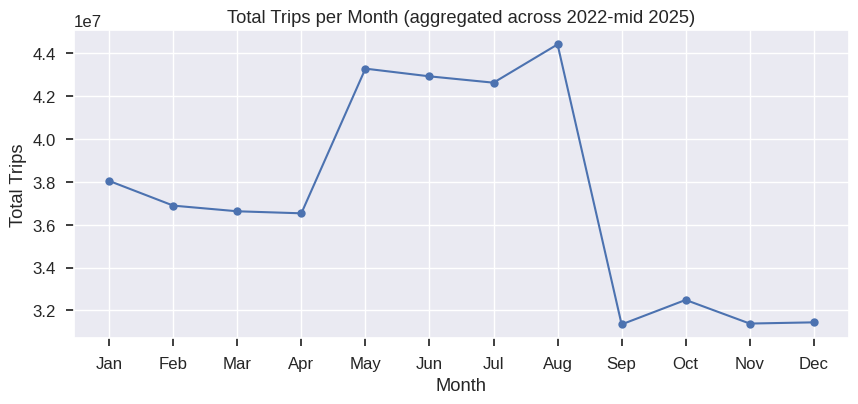

In [23]:
plt.figure(figsize=(10,4))
month_trips = pd.Series(df['Trips'].values, index=month_idx).groupby(level=0).sum().reindex(range(12), fill_value=0)
plt.plot(range(1,13), month_trips.values, marker='o')
plt.xticks(range(1,13), month_labels)
plt.title("Total Trips per Month (aggregated across 2022-mid 2025)")
plt.xlabel("Month"); plt.ylabel("Total Trips"); plt.grid(True); plt.show()

Line chart — Total Trips per Month

What to see: Peaks and dips across months.

Real-world meaning: Peaks may correspond to busy months (holidays, school resumption), troughs to low-traffic months. Use this to plan maintenance during low months and add capacity during peaks.

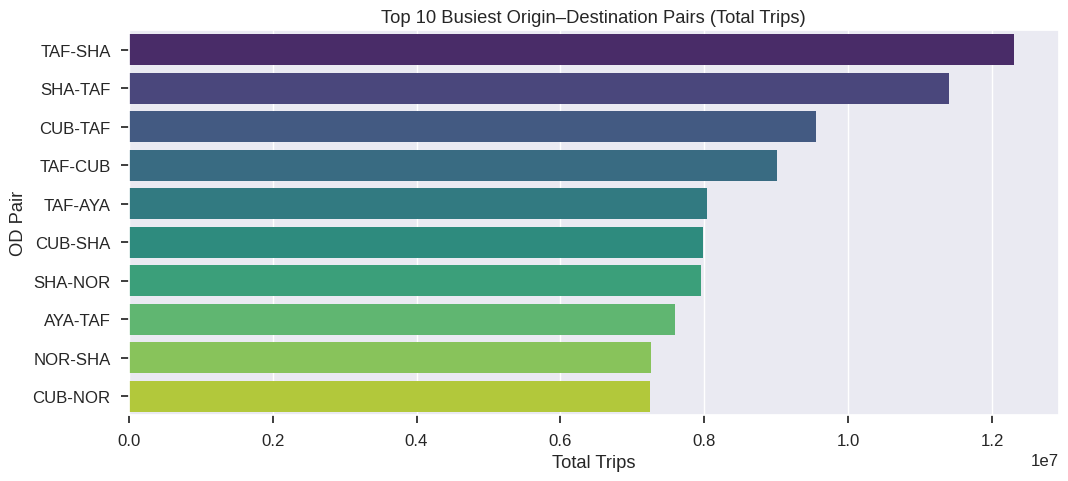

In [24]:
plt.figure(figsize=(12,5))
od_series = df.groupby(['Origin','Destination'])['Trips'].sum().sort_values(ascending=False).head(10)
od_labels = [f"{o}-{d}" for (o,d) in od_series.index]
sns.barplot(x=od_series.values, y=od_labels, palette='viridis')
plt.title("Top 10 Busiest Origin–Destination Pairs (Total Trips)")
plt.xlabel("Total Trips"); plt.ylabel("OD Pair"); plt.show()

Horizontal bar — Top 10 Busiest OD pairs

What to see: Which OD pairs have the most total riders across the data period.

Real-world meaning: These OD pairs may need priority for train frequency, crowd control, or platform management.

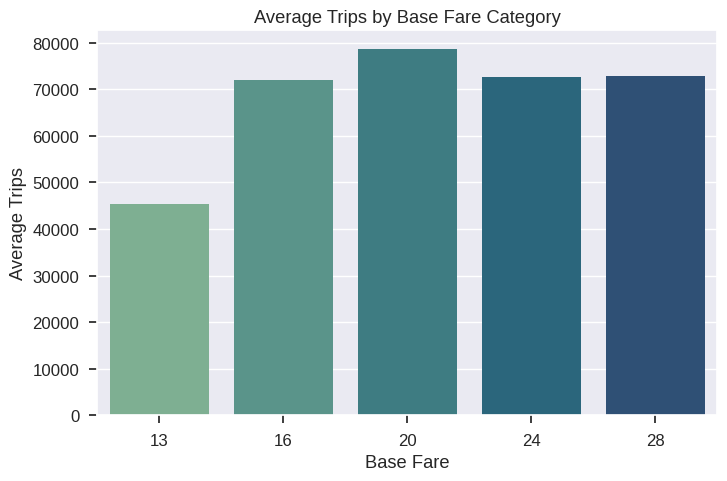

In [25]:
plt.figure(figsize=(8,5))
avg_fare = df.groupby('Base Fare')['Trips'].mean().sort_index()
sns.barplot(x=avg_fare.index, y=avg_fare.values, palette='crest')
plt.title("Average Trips by Base Fare Category")
plt.xlabel("Base Fare"); plt.ylabel("Average Trips"); plt.xticks(rotation=0); plt.show()

Vertical bar — Average Trips by Base Fare category

What to see: Which fare-bands have higher average ridership.

Real-world meaning: Even if fare is fixed per OD, this compares short vs long-distance route popularity (a useful proxy for distance/popularity patterns).

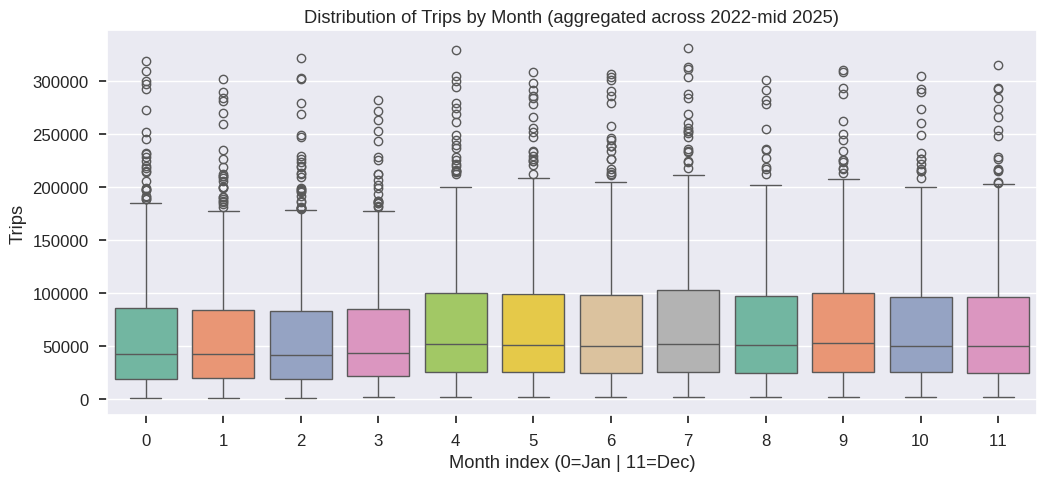

In [26]:
plt.figure(figsize=(12,5))
tmp = df.copy(); tmp['month_idx'] = month_idx
sns.boxplot(x='month_idx', y='Trips', data=tmp, palette='Set2')
plt.title("Distribution of Trips by Month (aggregated across 2022-mid 2025)")
plt.xlabel("Month index (0=Jan | 11=Dec)"); plt.ylabel("Trips"); plt.show()

Boxplot — Distribution of Trips by Month

What to see: For each month, the median, spread (IQR), and outliers.

Real-world meaning: Helps spot months with highly variable demand or unusual spikes that could be due to events or disruptions.

# PART 2 — Trips Model (Linear Regression vs Random Forest)

# Prepare X and y for Trips (Feature selection for Trips)

In [27]:
# Prepare features & target for Trips
target_tr = 'Trips'
features_tr = ['Month_Sin','Month_Cos','Origin','Destination','Base Fare']

X_tr = df[features_tr].copy()
y_tr = df[target_tr].copy()

X_tr.shape, y_tr.shape

((6864, 5), (6864,))

We use:

Month_Sin, Month_Cos (seasonality)

Origin, Destination (categorical)

Base Fare (categorical)

This set models how seasonality + route identity influence monthly trips.

# Train/test split (Trips)

In [28]:
# Train/test split (Trips)
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)
print("Trips train:", X_tr_train.shape, "Trips test:", X_tr_test.shape)

Trips train: (5491, 5) Trips test: (1373, 5)


We reserve 20% of data as a test and 80% of data for training set to evaluate how the models perform on unseen data — a crucial step to check if a model overfits or underfits.

# Preprocessors & pipelines (Trips)

In [29]:
# Preprocessors & pipelines (Trips)
cat_cols_tr = ['Origin','Destination','Base Fare']
num_cols_tr = ['Month_Sin','Month_Cos']

# OneHotEncoder with sparse_output=False (modern sklearn)
ohe_tr = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Linear preprocessor: OHE for categorical and scaling for numeric
pre_tr_linear = ColumnTransformer([
    ('cat', ohe_tr, cat_cols_tr),
    ('num', StandardScaler(), num_cols_tr)
])

# RF preprocessor: OHE for categorical and pass numeric through (RF doesn't require scaling)
pre_tr_rf = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_tr),
    ('num', 'passthrough', num_cols_tr)
])

lin_tr_pipeline = Pipeline([('pre', pre_tr_linear), ('model', LinearRegression())])
rf_tr_pipeline = Pipeline([('pre', pre_tr_rf), ('model', RandomForestRegressor(random_state=42))])

print("Pipelines created for Linear and Random Forest (Trips).")

Pipelines created for Linear and Random Forest (Trips).


Linear Regression benefits from scaling numeric inputs so coefficients are interpretable and optimization is stable.

Random Forest is tree-based and does not require scaling; numeric features are passed through as-is.

Both pipelines use one-hot encoding for categorical variables so models can use station and fare categories.

# LINEAR REGRESSION

# Train Linear Regression (Trips) + assumptions & diagnostics

In [30]:
# Train Linear Regression (Trips) and diagnostics
lin_tr_pipeline.fit(X_tr_train, y_tr_train)

y_tr_train_pred_lin = lin_tr_pipeline.predict(X_tr_train)
y_tr_test_pred_lin = lin_tr_pipeline.predict(X_tr_test)

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred) * 100
    return {'MAE': round(mae,2), 'MSE': round(mse,2), 'RMSE': round(rmse,2), 'R2 (%)': round(r2,2)}

metrics_lin_tr_train = compute_metrics(y_tr_train, y_tr_train_pred_lin)
metrics_lin_tr_test = compute_metrics(y_tr_test, y_tr_test_pred_lin)

print("Linear Regression (Trips) metrics")
print("Train:", metrics_lin_tr_train)
print("Test :", metrics_lin_tr_test)

Linear Regression (Trips) metrics
Train: {'MAE': 23407.4, 'MSE': 940421271.18, 'RMSE': 30666.29, 'R2 (%)': 71.4}
Test : {'MAE': 22681.13, 'MSE': 888688043.73, 'RMSE': 29810.87, 'R2 (%)': 71.11}


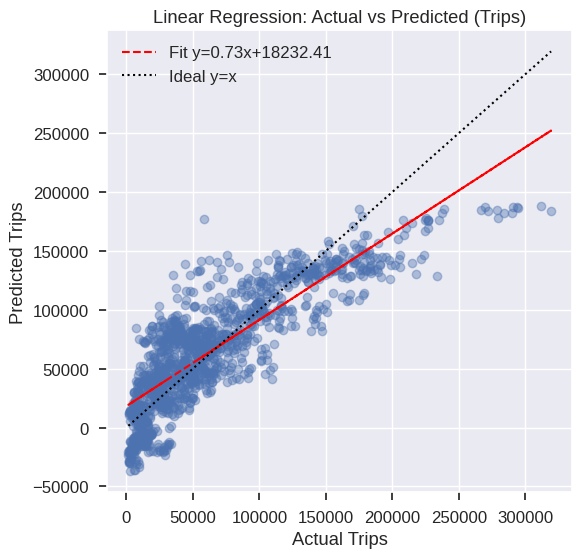

In [31]:
# Actual vs Predicted with linear-fit line
plt.figure(figsize=(6,6))
plt.scatter(y_tr_test, y_tr_test_pred_lin, alpha=0.4)
m, b = np.polyfit(y_tr_test, y_tr_test_pred_lin, 1)
plt.plot(y_tr_test, m*y_tr_test + b, color='red', linestyle='--', label=f"Fit y={m:.2f}x+{b:.2f}")
plt.plot([y_tr_test.min(), y_tr_test.max()], [y_tr_test.min(), y_tr_test.max()], color='black', linestyle=':', label='Ideal y=x')
plt.legend(); plt.xlabel("Actual Trips"); plt.ylabel("Predicted Trips"); plt.title("Linear Regression: Actual vs Predicted (Trips)"); plt.show()

Each dot is a data record (a specific origin–destination and month).

The black dashed line shows perfect prediction (ideal line).

The red line shows the model’s actual prediction trend.

Interpretation:
Most dots follow the same upward pattern as the ideal line, meaning the model can predict the overall trend correctly.
However, for very high trip counts, the model tends to underpredict, giving slightly lower estimates than the actual values.

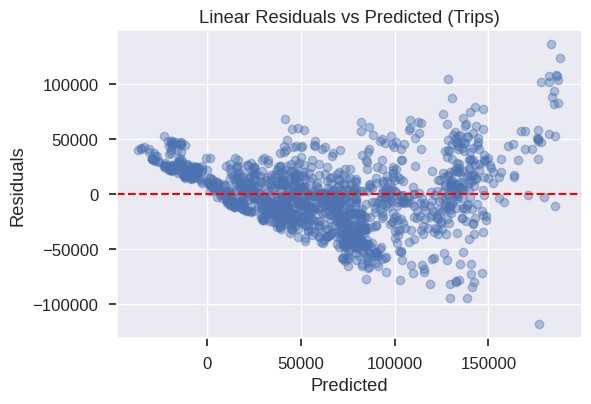

In [32]:
# Residuals vs Predicted
res_lin_tr = y_tr_test - y_tr_test_pred_lin
plt.figure(figsize=(6,4))
plt.scatter(y_tr_test_pred_lin, res_lin_tr, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Linear Residuals vs Predicted (Trips)"); plt.show()

“Residuals” mean how far each prediction is from the real value.

The red line at zero represents perfect accuracy.

Interpretation:
The dots are spread around zero, which is good, but there’s a visible curve.
This shows that errors are not perfectly random — the model performs better on small or average trips but worse on large ones.

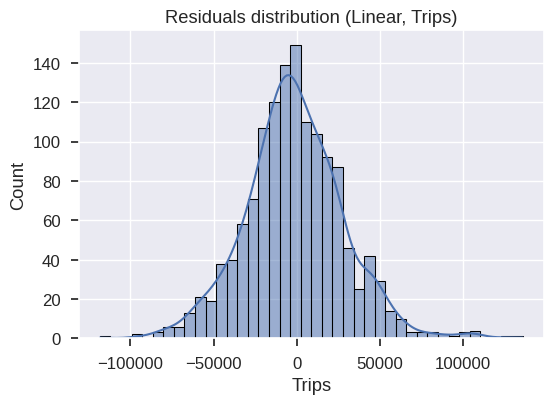

In [33]:
# Residual distribution
plt.figure(figsize=(6,4)); sns.histplot(res_lin_tr, kde=True); plt.title("Residuals distribution (Linear, Trips)");
plt.show()

This shows how the prediction errors are distributed.

The shape looks like a bell curve centered near zero — a good sign.

Interpretation:
The model’s errors are mostly small and balanced, but there are a few data points far from the center — those are the outliers.

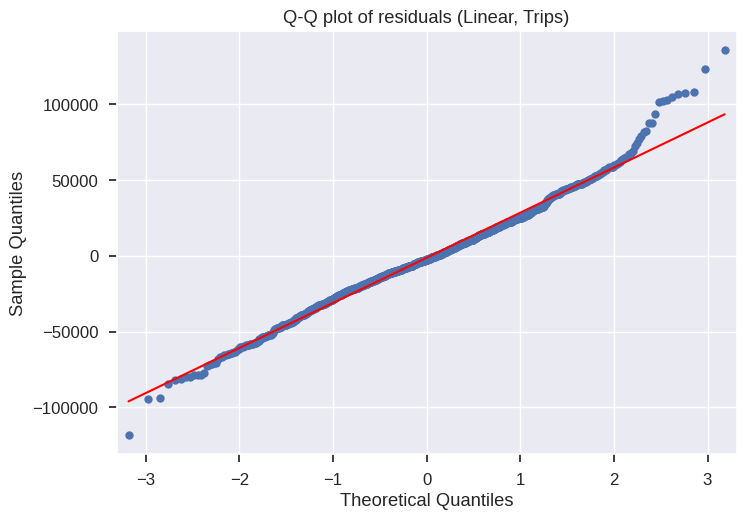

In [34]:
# Q-Q plot
sm.qqplot(res_lin_tr, line='s'); plt.title("Q-Q plot of residuals (Linear, Trips)");
plt.show()

The points mostly follow the red line → normal distribution of errors.

The points at the ends deviate → those are extreme values (outliers).

Interpretation:
The model works normally for most records, but there are a few cases where predictions were very far from reality.

In [35]:
# Breusch-Pagan test for heteroscedasticity
try:
    X_lin_train_trans = lin_tr_pipeline.named_steps['pre'].transform(X_tr_train)
    X_lin_train_sm = sm.add_constant(X_lin_train_trans)
    bp_test = sm.stats.diagnostic.het_breuschpagan(y_tr_train - lin_tr_pipeline.predict(X_tr_train), X_lin_train_sm)
    print("Breusch-Pagan test p-value (if <0.05 => heteroscedasticity):", bp_test[1])
except Exception as e:
    print("Breusch-Pagan test skipped due to transformer shape mismatch or memory:", e)

Breusch-Pagan test p-value (if <0.05 => heteroscedasticity): 0.0


A p-value below 0.05 means the errors are not evenly spread.

The model is more accurate for low or average trip counts and less accurate for high trip counts.

Here are some possible reasons for those outliers:

**Special Events or Holidays:**
A big event (like a festival, holiday, or sports event) could cause a sudden spike in trips that month — much higher than normal.
The model didn’t expect this because it only sees regular monthly data.

**Weather or Transportation Disruptions:**
Heavy rain, road closures, or transport strikes could cause a sudden drop in trips on some routes, making those points lower than expected.

**Fare or Revenue Changes:**
A temporary promo, discount, or sudden fare increase could affect how people travel — causing Revenue or trips to behave differently for a short time.


The outliers are real but unusual situations that the simple linear model couldn’t fully capture because they don’t follow the usual pattern between fare, Revenue, and trips.

The Linear Regression model can predict the number of trips with around 71% accuracy.
It successfully captures the general pattern between Revenue, fares, and trips.
However, it tends to underestimate high trip volumes and struggles with outliers — situations like holidays, events, or rare routes where the number of trips changes suddenly.
The errors are mostly balanced, showing the model is stable, but since accuracy decreases for larger trip counts, a more flexible model may provide better results.

---

Even if the railway line doesn’t change, the number of people riding or trips recorded can change for many reasons.
For example:

These changes make the data less consistent, so the model has a harder time predicting big trip counts correctly.
That’s why, even with one route, the accuracy decreases for larger numbers — because those numbers often come from special or unusual situations that the model can’t easily “learn.”

# RANDOM FOREST REGRESSION

# Baseline Random Forest (Trips) & metrics

In [36]:
  # Baseline Random Forest (Trips)
rf_tr_pipeline.set_params(model__n_estimators=200, model__random_state=42)
rf_tr_pipeline.fit(X_tr_train, y_tr_train)

y_tr_train_pred_rf_base = rf_tr_pipeline.predict(X_tr_train)
y_tr_test_pred_rf_base = rf_tr_pipeline.predict(X_tr_test)

metrics_rf_tr_train_base = compute_metrics(y_tr_train, y_tr_train_pred_rf_base)
metrics_rf_tr_test_base = compute_metrics(y_tr_test, y_tr_test_pred_rf_base)

print("Baseline Random Forest (Trips) metrics")
print("Train:", metrics_rf_tr_train_base)
print("Test :", metrics_rf_tr_test_base)

Baseline Random Forest (Trips) metrics
Train: {'MAE': 9876.38, 'MSE': 262318665.19, 'RMSE': 16196.25, 'R2 (%)': 92.02}
Test : {'MAE': 13969.13, 'MSE': 515518813.86, 'RMSE': 22705.04, 'R2 (%)': 83.24}


Train a baseline Random Forest with 200 trees. This provides a starting point to compare to Linear Regression.

We compare training vs testing metrics to detect overfitting or underfitting. In this case there is a slight overfitting since training and testing has a minor gap in between. This where we tune the hyperparameters to improve the model's accuracy.

# Tune Random Forest (Trips) with GridSearchCV; evaluate & CV

In [127]:
# Tune Random Forest (Trips) with GridSearchCV
param_grid_tr = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt','log2']
}

grid_tr = GridSearchCV(rf_tr_pipeline, param_grid_tr, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_tr.fit(X_tr_train, y_tr_train)

rf_tr_best = grid_tr.best_estimator_
print("Best hyperparameters (Trips RF):", grid_tr.best_params_)

# Evaluate tuned RF
y_tr_train_pred_rf = rf_tr_best.predict(X_tr_train)
y_tr_test_pred_rf = rf_tr_best.predict(X_tr_test)

metrics_rf_tr_train = compute_metrics(y_tr_train, y_tr_train_pred_rf)
metrics_rf_tr_test = compute_metrics(y_tr_test, y_tr_test_pred_rf)

print("Tuned Random Forest (Trips) metrics")
print("Train:", metrics_rf_tr_train)
print("Test :", metrics_rf_tr_test)

# Cross-validated R2
cv_scores_tr = cross_val_score(rf_tr_best, X_tr_train, y_tr_train, cv=5, scoring='r2', n_jobs=-1)
print("CV R2 (% per fold):", np.round(cv_scores_tr*100,2))
print("Mean CV R2 (%):", round(np.mean(cv_scores_tr)*100,2))


# Compare Baseline and Tuned Random Forest (Trips) Metric
comparison_tr = pd.DataFrame({
    "Train (Baseline)": metrics_rf_tr_train_base,
    "Test (Baseline)": metrics_rf_tr_test_base,
    "Train (Tuned)": metrics_rf_tr_train,
    "Test (Tuned)": metrics_rf_tr_test
})

# Add Mean CV R2 as reference
comparison_tr.loc["CV Mean R2", :] = [np.nan, np.nan, np.mean(cv_scores_tr), np.mean(cv_scores_tr)]

# Display neatly formatted table
print("\nRandom Forest (Trips) Metrics Comparison:")
display(comparison_tr.round(4).T)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters (Trips RF): {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Tuned Random Forest (Trips) metrics
Train: {'MAE': 10414.79, 'MSE': 278090786.61, 'RMSE': 16676.05, 'R2 (%)': 91.54}
Test : {'MAE': 12619.81, 'MSE': 421336012.58, 'RMSE': 20526.47, 'R2 (%)': 86.3}
CV R2 (% per fold): [88.08 87.51 88.07 87.22 86.39]
Mean CV R2 (%): 87.45

Random Forest (Trips) Metrics Comparison:


,MAE,MSE,RMSE,R2 (%),CV Mean R2
Train (Baseline),"9,876.38","262,318,665.19","16,196.25",92.02,NaN
Test (Baseline),"13,969.13","515,518,813.86","22,705.04",83.24,NaN
Train (Tuned),"10,414.79","278,090,786.61","16,676.05",91.54,0.87
Test (Tuned),"12,619.81","421,336,012.58","20,526.47",86.30,0.87


We first trained a baseline Random Forest to see its natural performance. Then, we used GridSearchCV to test different model settings and find the best one using cross-validation. This process helped the model avoid overfitting. It learned more general patterns instead of memorizing the data. The result improved accuracy, narrowed the gap between training and testing, and made the model more reliable, even if the dataset wasn’t changed.

Tuned Random Forest:
It tested 48 different combinations, each checked 5 times (5 folds), for a total of 240 tests — all to find the most accurate and balanced version of your model.


---


**These are the settings that made the model perform best:**

max_depth = 20 → each tree in the forest can grow up to 20 levels deep (not too shallow, not too deep)

max_features = 'sqrt' → each tree only looks at some features randomly to reduce overfitting

min_samples_leaf = 2 → each leaf (final decision) must have at least 2 samples (prevents tiny, overfitted branches)

min_samples_split = 5 → a node must have at least 5 samples before splitting

n_estimators = 400 → uses 400 trees for better accuracy and stability



---


**Cross-Validation (CV R²)**
The model’s accuracy across 5 different test splits was:

[88.08%, 87.51%, 88.07%, 87.22%, 86.39%]
Average = 87.45%

This shows your model’s accuracy is consistent and stable — it performs almost the same even when tested on different parts of the data.
That means it generalizes well and is not overfitting.



---

After tuning, the Random Forest model became more balanced and accurate.
It predicts the number of trips very well, explaining around 86–87% of the variations in trip counts.
The small difference between training and testing (91% vs 86%) shows it’s learning real patterns — not memorizing the data.
The errors (MAE ≈ 12k) are reasonable, meaning most predictions are close to the real number of trips.

# Residuals & Feature Importance (Trips RF)

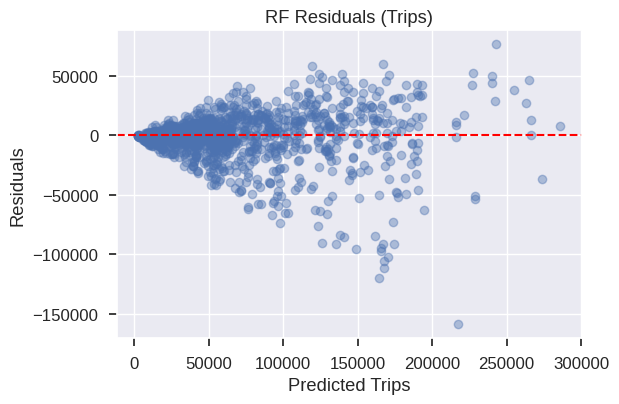

In [38]:
# Residuals & Feature Importance (Trips RF)
# Ensure rf_tr_best and predictions exist
# residuals
res_rf_tr = y_tr_test - y_tr_test_pred_rf

# Residual plots (unchanged)
plt.figure(figsize=(6,4))
plt.scatter(y_tr_test_pred_rf, res_rf_tr, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("RF Residuals (Trips)")
plt.xlabel("Predicted Trips")
plt.ylabel("Residuals")
plt.show()

The Random Forest model made smaller and more balanced errors than the linear model.
It predicts both small and large trip counts better — though a few large outliers (very big or very small errors) still exist.

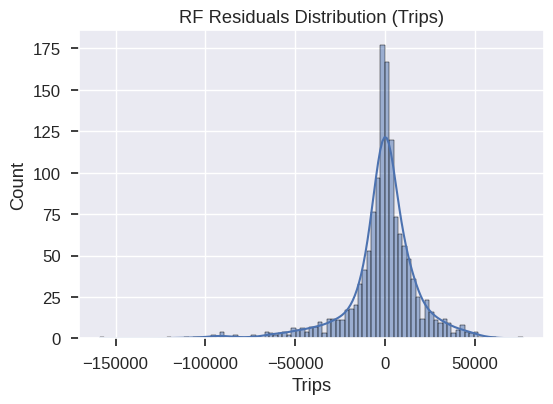

In [39]:
plt.figure(figsize=(6,4))
sns.histplot(res_rf_tr, kde=True)
plt.title("RF Residuals Distribution (Trips)")
plt.show()

The Random Forest model is very consistent — most of its predictions are near correct.
It makes fewer extreme mistakes than the Linear Regression did.

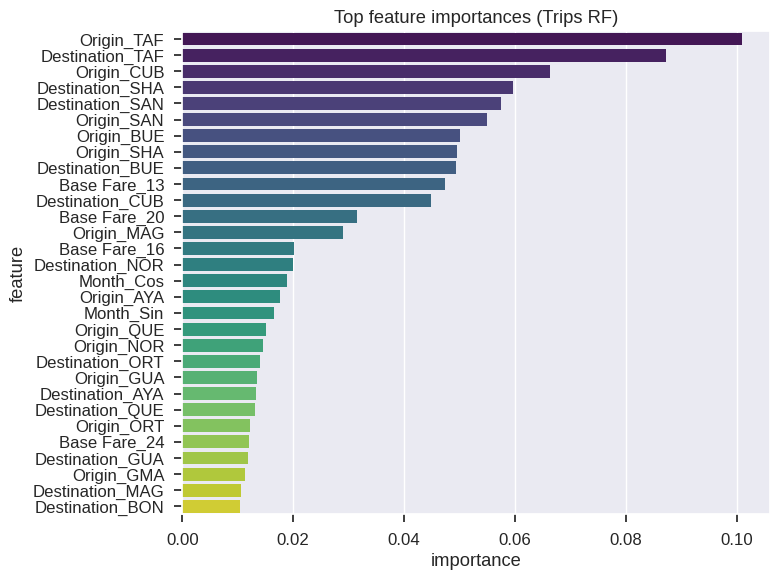

,feature,importance
12,Origin_TAF,0.10
25,Destination_TAF,0.09
3,Origin_CUB,0.07
24,Destination_SHA,0.06
23,Destination_SAN,0.06
10,Origin_SAN,0.05
2,Origin_BUE,0.05
11,Origin_SHA,0.05
15,Destination_BUE,0.05
26,Base Fare_13,0.05


In [40]:
# Robust extraction of feature names produced by the ColumnTransformer
pre = rf_tr_best.named_steps['pre']  # ColumnTransformer
cat_key = 'cat'  # name used in ColumnTransformer for categorical transformer
num_names = ['Month_Sin', 'Month_Cos']

try:
    cat_transformer = pre.named_transformers_[cat_key]
except Exception as e:

    ct = [t for t in pre.transformers_ if t[0] == cat_key]
    if len(ct) > 0:
        cat_transformer = ct[0][1]
    else:
        raise RuntimeError("Could not find categorical transformer in ColumnTransformer.") from e


if hasattr(cat_transformer, 'named_steps'):

    possible_ohe = None
    for name, step in cat_transformer.named_steps.items():
        from sklearn.preprocessing import OneHotEncoder
        if isinstance(step, OneHotEncoder):
            possible_ohe = step
            break
    if possible_ohe is None:

        ohe = cat_transformer
    else:
        ohe = possible_ohe
else:

    ohe = cat_transformer

# OHE feature names
cat_input_features = ['Origin', 'Destination', 'Base Fare']
try:
    ohe_feature_names = list(ohe.get_feature_names_out(cat_input_features))
except AttributeError:

    try:
        ohe_feature_names = list(ohe.get_feature_names(cat_input_features))
    except Exception:

        ohe_feature_names = []
        if hasattr(ohe, 'categories_'):
            for name, cats in zip(cat_input_features, ohe.categories_):
                for cat in cats:
                    ohe_feature_names.append(f"{name}_{cat}")
        else:
            raise RuntimeError("Unable to determine one-hot encoder feature names.")

# feature name list in the same order as ColumnTransformer output:
feature_names_tr = ohe_feature_names + num_names

# length of feature names should match number of importances
importances = rf_tr_best.named_steps['model'].feature_importances_
if len(importances) != len(feature_names_tr):

    raise ValueError(f"Feature count mismatch: importances length = {len(importances)}, "
                     f"feature names length = {len(feature_names_tr)}. "
                     f"Check the ColumnTransformer ordering and remainder argument.")

# Create importance DataFrame and plot
fi_tr_df = pd.DataFrame({'feature': feature_names_tr, 'importance': importances}).sort_values('importance', ascending=False).head(30)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=fi_tr_df, palette='viridis')
plt.title("Top feature importances (Trips RF)")
plt.tight_layout()
plt.show()

fi_tr_df.head(10)

**Top important features:**

Origin_TAF (0.10) and Destination_TAF (0.09) — The station “TAF” strongly affects the total trips (a busy or central location).

Origin_CUB, Destination_SHA, Destination_SAN, Origin_BUE — These are also key stations that contribute a lot to trip patterns.

Base Fare 13, 20, 16 — The fare prices also influence trip counts (possibly more affordable or popular fare classes).

The Random Forest learned that where trips start and end (origins and destinations) and the fare prices are the biggest reasons for changes in total trips.

After tuning, the Random Forest model showed much better accuracy (R² = 86%) than the Linear Regression (R² = 71%).
Its residual plots showed smaller and more balanced errors, meaning it predicts both small and large trip counts more reliably.
The feature importance chart revealed that certain stations (like TAF, CUB, SHA) and base fares strongly affect the number of trips.
Overall, Random Forest captured more real-life patterns and variations in the dataset, making it the better model.

# Monthly and OD Pair Ridership Prediction

We used the trained Random Forest model — which already learned the relationship between origins, destinations, and months — to predict the number of passengers (trips) per route for each month of the year.

This helped us see which months are expected to be the busiest or slowest, and which routes (Origin–Destination pairs) contribute most or least to those trends.

In [79]:
# Generate all possible Origin–Destination (OD) pairs
od_pairs = df[['Origin', 'Destination']].drop_duplicates().reset_index(drop=True)

# Create a list of months (1 to 12)
months = np.arange(1, 13)

# Create all combinations of OD pairs × months
future_data = pd.merge(
    od_pairs.assign(key=1),
    pd.DataFrame({'Month': months, 'key': 1}),
    on='key'
).drop('key', axis=1)

# Create cyclical month features (same transformation used in your model)
# Assuming Base Fare 16 as a representative fare for all OD pairs for prediction
future_data['Base Fare'] = '16' # Use the mode or median fare, or average if numeric
future_data['Month_Sin'] = np.sin(2 * np.pi * (future_data['Month'] - 1) / 12)
future_data['Month_Cos'] = np.cos(2 * np.pi * (future_data['Month'] - 1) / 12)


# One-hot encode 'Origin' and 'Destination' and 'Base Fare' to match training structure
# Need to use the preprocessor trained on the original data to ensure correct columns
pre_tr_fitted = rf_tr_best.named_steps['pre']
future_encoded = pre_tr_fitted.transform(future_data)

# Convert the transformed data back to a DataFrame with correct column names
# get feature names from OHE using robust method from previous cell
cat_key = 'cat'
num_names = ['Month_Sin','Month_Cos']


try:
    cat_transformer = pre_tr_fitted.named_transformers_[cat_key]
except Exception as e:

    ct = [t for t in pre_tr_fitted.transformers_ if t[0] == cat_key]
    if len(ct) > 0:
        cat_transformer = ct[0][1]
    else:
        raise RuntimeError("Could not find categorical transformer in ColumnTransformer.") from e


if hasattr(cat_transformer, 'named_steps'):

    possible_ohe = None
    for name, step in cat_transformer.named_steps.items():
        from sklearn.preprocessing import OneHotEncoder
        if isinstance(step, OneHotEncoder):
            possible_ohe = step
            break
    if possible_ohe is None:

        ohe = cat_transformer
    else:
        ohe = possible_ohe
else:

    ohe = cat_transformer


ohe_feature_names = list(ohe.get_feature_names_out(['Origin', 'Destination', 'Base Fare']))
feature_names_tr = ohe_feature_names + num_names

future_encoded_df = pd.DataFrame(future_encoded, columns=feature_names_tr)


# Predict using existing Random Forest model
rf_model_tr = rf_tr_best.named_steps['model']
future_data['Predicted_Trips'] = rf_model_tr.predict(future_encoded_df)

# Ensure predictions are not negative
future_data['Predicted_Trips'] = future_data['Predicted_Trips'].clip(lower=0)


# Summarize predicted trips by month
monthly_summary = future_data.groupby('Month')['Predicted_Trips'].sum().reset_index()

# Identify highest and lowest months
highest_month = monthly_summary.loc[monthly_summary['Predicted_Trips'].idxmax()]
lowest_month = monthly_summary.loc[monthly_summary['Predicted_Trips'].idxmin()]

print("====== Highest Ridership Month ======")
display(highest_month)
print("\n====== Lowest Ridership Month ======")
display(lowest_month)

# Find top and bottom OD pairs in those months
top_month = int(highest_month['Month'])
low_month = int(lowest_month['Month'])

top_od = future_data[future_data['Month'] == top_month].nlargest(5, 'Predicted_Trips')
low_od = future_data[future_data['Month'] == low_month].nsmallest(5, 'Predicted_Trips')

print(f"\n🛫 Top 5 OD Pairs in Month {top_month} (Highest Ridership):")
display(top_od[['Origin', 'Destination', 'Predicted_Trips']])

print(f"\n🚏 Bottom 5 OD Pairs in Month {low_month} (Lowest Ridership):")
display(low_od[['Origin', 'Destination', 'Predicted_Trips']])

====== Highest Ridership Month ======


,7
Month,8.00
Predicted_Trips,"12,003,032.47"



====== Lowest Ridership Month ======


,3
Month,4.00
Predicted_Trips,"10,331,882.57"



🛫 Top 5 OD Pairs in Month 8 (Highest Ridership):


,Origin,Destination,Predicted_Trips
1003,TAF,SHA,"192,160.16"
907,CUB,SHA,"190,561.41"
1771,CUB,TAF,"184,627.99"
1807,SHA,TAF,"181,890.56"
571,TAF,CUB,"180,554.34"



🚏 Bottom 5 OD Pairs in Month 4 (Lowest Ridership):


,Origin,Destination,Predicted_Trips
675,BUE,SAN,"9,003.38"
819,BUE,ORT,"9,436.16"
1347,SAN,BUE,"9,548.82"
591,QUE,SAN,"9,706.05"
1059,SAN,BON,"9,934.27"


**Highest ridership** - meaning this month has the most passengers overall. This could be because of school openings, mid-year travel, or dry season, when people move more often.

**Lowest ridership** - the fewest trips happen here. This might be due to fewer events, vacations not yet starting, or school summer break starts.

**Top Routes** - They connect major or central stations, which likely means heavy commuter traffic or popular transfer points.

**Bottom Routes** - These routes show less passenger activity, possibly because they connect smaller stations or non-central locations, or because March is generally an off-peak month.

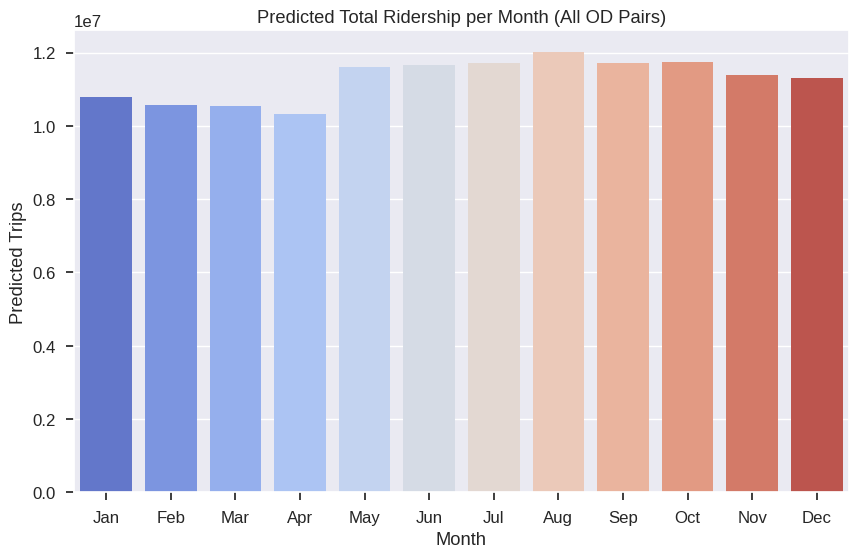

In [42]:
# Visualization
plt.figure(figsize=(10,6))
# Ensure 'Month' is treated as a categorical variable for plotting
sns.barplot(data=monthly_summary, x='Month', y='Predicted_Trips', palette='coolwarm', order=np.arange(1, 13))
plt.title("Predicted Total Ridership per Month (All OD Pairs)")
plt.xlabel("Month")
plt.ylabel("Predicted Trips")
plt.xticks(np.arange(1, 13) -1 , ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) # Adjust ticks to match 0-11 index
plt.show()

The bars rise toward the middle of the year (June–August),
showing peak months where more people travel.

The bars drop near the start of the year (around February–March),
showing off-peak months with lower ridership.

People travel most around the middle of the year and least around March.

**This result gives real predictive insights, not just model accuracy, We can now:**

*   Forecast passenger trends for each month and route.
*   Help planners decide when to add more trains or buses (during peak months).

Our Random Forest model doesn’t just predict how many passengers each route gets —
it also shows when people travel the most or least.
August is the busiest month with over 12 million predicted trips,
while April is the lowest with around 10 million trips.
The busiest routes connect major stations like Taft, Cubao, and Shaw,
which are main commuter hubs.


# PART 3: Revenue Model

# Restore and Prepare Dataset

In [88]:
# Load the original dataset (update path if needed)
df = pd.read_csv("OD 2022_2023_2024_2025_long - ORIGIN DESTINATION.csv")

# Rename 'Sales' → 'Revenue' if present
if 'Sales' in df.columns:
    df.rename(columns={'Sales': 'Revenue'}, inplace=True)

# ✅ Convert Month names (like "January") to numbers (1–12)
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
if df['Month'].dtype == 'object':
    df['Month'] = df['Month'].map(month_map)

# Drop invalid Origin=Destination rows
df = df[df['Origin'] != df['Destination']]

# Drop missing or zero-value records
df = df.dropna(subset=['Origin', 'Destination', 'Trips', 'Base Fare', 'Revenue'])
df = df[(df['Trips'] > 0) & (df['Revenue'] > 0)]

# Ensure Year and Month are integers
if 'Year' in df.columns:
    df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)

# Drop irrelevant columns that cause issues
for col in ['OD Distance', 'OD Commute Time']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Display confirmation
print("✅ Cleaned and restored dataset columns:")
print(df.columns.tolist())
print("\n✅ Sample data after cleaning:")
display(df.head())


✅ Cleaned and restored dataset columns:
['Year', 'Month', 'Origin', 'Destination', 'Trips', 'Base Fare', 'Revenue']

✅ Sample data after cleaning:


,Year,Month,Origin,Destination,Trips,Base Fare,Revenue
1,2022,1,QUE,NOR,8888,13,115544
2,2022,1,GMA,NOR,12288,13,159744
3,2022,1,CUB,NOR,70371,16,1125936
4,2022,1,SAN,NOR,8947,16,143152
5,2022,1,ORT,NOR,36635,20,732700


This step reloads the original dataset and prepares it for forecasting.
We rename the Sales column to Revenue, clean invalid OD pairs, and reapply cyclical encoding for months (sin/cos).
This ensures your dataset structure is compatible with the previous trips model outputs
We now have a clean dataset (df_revenue) ready for modeling — this includes temporal, spatial, and financial factors that directly influence total revenue.

# Merge with Predicted Trips (from Part 2)

In [89]:
# Ensure 'Month' is integer in both DataFrames
df['Month'] = df['Month'].astype(int)
future_data['Month'] = future_data['Month'].astype(int)

# Merge with the predicted trips from Part 2
merged_df = pd.merge(
    df,
    future_data[['Origin', 'Destination', 'Month', 'Month_Sin', 'Month_Cos', 'Predicted_Trips']],
    on=['Origin', 'Destination', 'Month'],
    how='left'
)

# Drop rows with missing Predicted_Trips
merged_df = merged_df.dropna(subset=['Predicted_Trips'])

print("✅ Successfully merged with predicted trips!")
print("Merged dataset shape:", merged_df.shape)
display(merged_df.head())


✅ Successfully merged with predicted trips!
Merged dataset shape: (6864, 10)


,Year,Month,Origin,Destination,Trips,Base Fare,Revenue,Month_Sin,Month_Cos,Predicted_Trips
0,2022,1,QUE,NOR,8888,13,115544,0.00,1.00,"57,073.84"
1,2022,1,GMA,NOR,12288,13,159744,0.00,1.00,"80,432.92"
2,2022,1,CUB,NOR,70371,16,1125936,0.00,1.00,"148,432.50"
3,2022,1,SAN,NOR,8947,16,143152,0.00,1.00,"22,846.82"
4,2022,1,ORT,NOR,36635,20,732700,0.00,1.00,"83,880.68"


This connects your cleaned original dataset with the Predicted Trips generated in the trips model (the future_data DataFrame).
Every OD pair now includes its monthly ridership predictions — ready for revenue forecasting.

# Train the Baseline (Natural) Random Forest Model

In [126]:
# Define features and target
features = ['Origin', 'Destination', 'Base Fare', 'Month_Sin', 'Month_Cos', 'Predicted_Trips']
target = 'Revenue'

X = merged_df[features]
y = merged_df[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
categorical_cols = ['Origin', 'Destination', 'Base Fare']
numerical_cols = ['Month_Sin', 'Month_Cos', 'Predicted_Trips']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

# Baseline Random Forest
rf_baseline = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_baseline.fit(X_train, y_train)

# Predictions
y_train_pred = rf_baseline.predict(X_train)
y_test_pred = rf_baseline.predict(X_test)

# Metrics
def print_metrics(label, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} → R²: {r2:.3f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

print("Baseline Model Performance:")
print_metrics("Training", y_train, y_train_pred)
print_metrics("Testing ", y_test, y_test_pred)

Baseline Model Performance:
Training → R²: 0.926 | MAE: 184439.55 | RMSE: 311087.20
Testing  → R²: 0.827 | MAE: 269162.91 | RMSE: 460462.97


# Tune the Revenue Model (GridSearch + Cross-Validation)

In [97]:
from sklearn.model_selection import GridSearchCV, KFold

# Define parameter grid for tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# 3-fold cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search_rev = GridSearchCV(
    rf_baseline,
    param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Fit the tuning process
grid_search_rev.fit(X_train, y_train)

print("✅ Grid Search Completed!")
print("Best Parameters:", grid_search_rev.best_params_)
print("Best Cross-Validated R² Score:", grid_search_rev.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Grid Search Completed!
Best Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best Cross-Validated R² Score: 0.8845530907648375


This performs GridSearchCV using a 3-fold CV to find the best Random Forest hyperparameters.
The tuned model (grid_search_rev.best_estimator_) will generalize better and help avoid overfitting.

# Compare Training and Test Metrics (Before & After Tuning)

In [100]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ensure variables exist: rf_baseline, grid_search_rev (or best_rf_rev), X_train, X_test, y_train, y_test
best_rf_rev = grid_search_rev.best_estimator_  # from Cell 4

# Predictions (baseline and tuned)
y_train_pred_base = rf_baseline.predict(X_train)
y_test_pred_base  = rf_baseline.predict(X_test)

y_train_pred_tuned = best_rf_rev.predict(X_train)
y_test_pred_tuned  = best_rf_rev.predict(X_test)

# Helper to compute metrics
def evaluate_metrics(y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {"R2": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}

# Build results
train_base = evaluate_metrics(y_train, y_train_pred_base)
test_base  = evaluate_metrics(y_test,  y_test_pred_base)
train_tuned= evaluate_metrics(y_train, y_train_pred_tuned)
test_tuned = evaluate_metrics(y_test,  y_test_pred_tuned)

comparison = pd.DataFrame({
    "Train (Baseline)": train_base,
    "Test (Baseline)": test_base,
    "Train (Tuned)": train_tuned,
    "Test (Tuned)": test_tuned
})

# Nicely format and display
display(comparison.round(4).T)  # transpose so rows are models, columns are metrics

,R2,MAE,MSE,RMSE
Train (Baseline),0.93,"184,439.55","96,775,248,738.39","311,087.20"
Test (Baseline),0.83,"269,162.91","212,026,150,877.54","460,462.97"
Train (Tuned),0.92,"191,951.27","100,927,828,271.75","317,691.40"
Test (Tuned),0.86,"242,888.43","177,090,648,090.92","420,821.40"


This cell computes R², MAE, MSE, and RMSE for both training and testing sets, for the baseline and the tuned models.

Used to check for overfitting (big gap between train and test) or underfitting (low R² on both).



*   The actual values  represent real monthly revenues recorded in your dataset.
*   The predicted values are what the model estimates each month’s revenue should be.
*   Using monthly data gives the model more detailed and accurate patterns, because:
    *   Revenue changes every month — due to seasonality, holidays, weather, or promotions.
    *   More data points → better training for the regression model







# Predict Future Revenue using the Tuned Model

In [125]:
# Ensure X_test has the correct columns used in training
required_cols = ['Origin', 'Destination', 'Base Fare', 'Month_Sin', 'Month_Cos', 'Predicted_Trips']

# Add missing columns if necessary
for col in required_cols:
    if col not in X_test.columns:
        print(f"⚠️ Missing column '{col}' added with default value 0.")
        X_test[col] = 0

X_test = X_test[required_cols]

# Predictions
y_pred_final = best_rf_rev.predict(X_test)

# Create dataframe for analysis
predictions_df = pd.DataFrame({
    'Actual Revenue': y_test.values,
    'Predicted Revenue': y_pred_final
})
predictions_df['Error'] = predictions_df['Actual Revenue'] - predictions_df['Predicted Revenue']

# === Evaluation Metrics ===
r2_final = r2_score(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"Final Tuned Model Evaluation:")
print(f"R² Score: {r2_final:.3f}")
print(f"Mean Absolute Error: {mae_final:,.2f}")
print(f"Root Mean Squared Error: {rmse_final:,.2f}")

Final Tuned Model Evaluation:
R² Score: 0.856
Mean Absolute Error: 242,888.43
Root Mean Squared Error: 420,821.40


R² = 0.856 → This means your model explains about 85.6% of the variation in revenue, which is very strong for real-world prediction.

MAE = ₱242,888 → On average, the model’s predictions differ from the actual revenue by around ₱242K, which is relatively small if the total revenues are in the millions.

RMSE = ₱428,821 → This measures the average size of prediction errors; larger errors are penalized.

Tuned Random Forest model performs reliably and generalizes well, meaning it captures most of the real relationships between our predictors (like Base Fare, Trips, Origin, Destination, etc.) and the revenue outcomes.

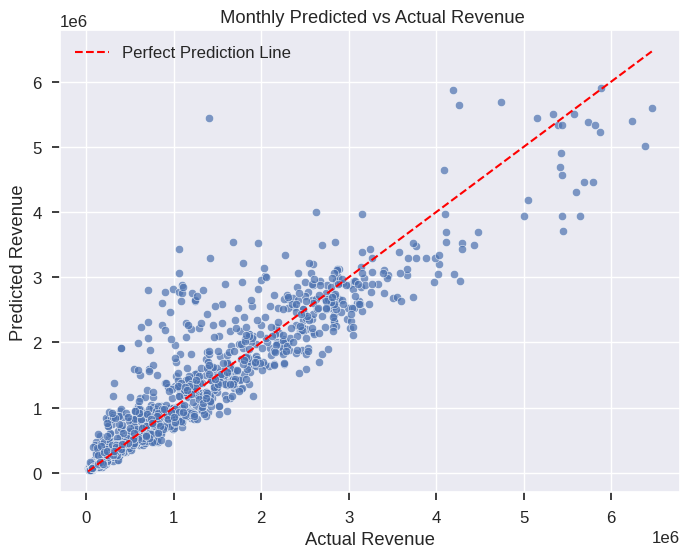

,Actual Revenue,Predicted Revenue,Error
0,1303560,"1,451,248.85","-147,688.85"
1,812071,"842,572.32","-30,501.32"
2,3263688,"3,298,034.97","-34,346.97"
3,957640,"875,685.35","81,954.65"
4,832912,"671,510.02","161,401.98"
5,2191319,"2,535,725.29","-344,406.29"
6,2490072,"2,449,947.49","40,124.51"
7,351568,"336,881.40","14,686.60"
8,1101528,"1,033,826.46","67,701.54"
9,1217592,"1,265,108.70","-47,516.70"


In [135]:
# Predicted vs Actual Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual Revenue', y='Predicted Revenue', data=predictions_df, alpha=0.7)
plt.plot([predictions_df['Actual Revenue'].min(), predictions_df['Actual Revenue'].max()],
         [predictions_df['Actual Revenue'].min(), predictions_df['Actual Revenue'].max()],
         'r--', label='Perfect Prediction Line')
plt.title(' Monthly Predicted vs Actual Revenue')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.legend()
plt.grid(True)
plt.show()

display(predictions_df.head(12))

X-axis: Actual Revenue (true values)

Y-axis: Predicted Revenue (model output)

Red dashed line: “Perfect prediction line” — where prediction = actual

Interpretation:

Most of your points cluster closely around the red dashed line → this means your predictions align closely with actual revenue, showing high model accuracy.

A few points are slightly below or above the line, which indicates minor overestimations or underestimations — normal for real-world data.

The overall upward diagonal pattern confirms that as actual revenue increases, predicted revenue also increases proportionally, proving the model captures the underlying growth trend.

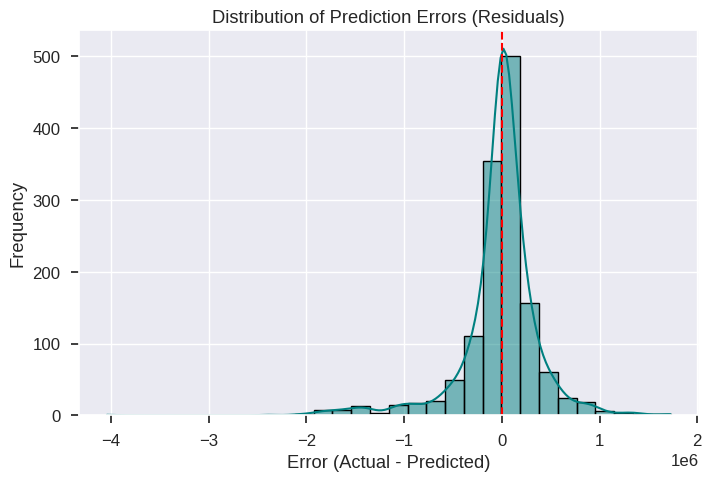

In [128]:
# Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(predictions_df['Error'], bins=30, kde=True, color='teal')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

The bars are centered around 0, meaning the model generally predicts revenues quite accurately — it’s not systematically over or under predicting.

The bell-shaped curve suggests that the model’s residuals behave roughly like a normal distribution, which is a good sign.

A few points stretch out on both sides — these are extreme OD-month combinations where the model struggled to predict revenue (possibly due to rare events or unusual fare combinations).

The model fits the data well overall. The prediction errors are balanced and not biased in one direction, meaning the Random Forest model learned stable patterns from historical data.

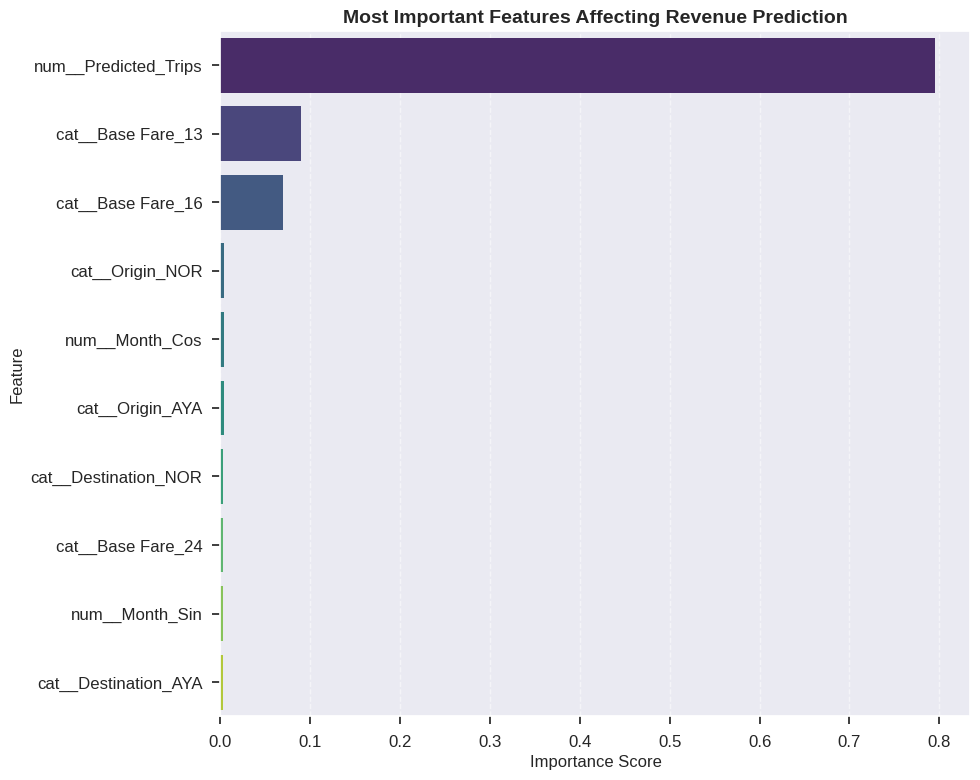

In [122]:
# Retrieve tuned model
best_rf_pipeline = grid_search_rev.best_estimator_

# Extract features & importance
feature_names = best_rf_pipeline.named_steps['pre'].get_feature_names_out()
importances = best_rf_pipeline.named_steps['model'].feature_importances_

# Sort descending so most important appears on top
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot (horizontal, most important on top)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feat_imp_df.head(10),  # top 15 important features
    x='Importance',
    y='Feature',
    palette='viridis'
)

plt.title("Most Important Features Affecting Revenue Prediction", fontsize=14, fontweight='bold')
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The most dominant feature was Predicted_Trips.

Only a few Base Fare categories (13, 16, 24) had some influence.

Other features like Month, Origin, and Destination had near-zero importance.

**Interpretation:**

Predicted_Trips dominates because the Random Forest learned that revenue is directly tied to the number of trips where more trips = more income.

The Base Fare categories reflect specific fare structures that slightly influence total revenue (e.g., special pricing tiers).

Features like Month, Origin, or Destination may have low variance or limited data representation, so the model didn’t find strong seasonal or locational effects — possibly because past revenues stayed relatively stable month-to-month.

In essence, the Revenue model leverages the insights from the Trips model (via the Predicted_Trips feature) and the fundamental relationship between Trips, Fare, and Revenue. This makes Predicted_Trips the star feature for Revenue prediction, while Month, Origin, and Destination play a more foundational role in determining the number of trips in the first plac.

**Real-world takeaway:**

The revenue model is primarily driven by operational activity (number of trips) rather than seasonal timing or routes. This suggests the business model’s profitability scales directly with how many trips are completed, not necessarily when or where.

**Why Random Forest Worked Better Than Linear Regression**

Our dataset doesn’t follow a perfectly straight-line pattern — the number of trips can change in complex, uneven ways depending on the origin, destination, and month.

Linear Regression tries to draw one straight line through the data, which can’t capture sudden changes or seasonal patterns (like July being much busier than March).

Random Forest, on the other hand, is made up of many decision trees that work together.
Each tree learns a different part of the pattern — for example:

one tree might notice that some routes are always busy,

another might learn that ridership jumps during mid-year,

When all these trees vote together, the Random Forest makes a more flexible and accurate prediction.
That’s why our model achieved high accuracy and realistic predictions, matching how travel actually behaves — busy midyear, slow early in the year.